In [1]:
import wandb, pdb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('dark')

In [2]:
edges = {

    'd6_ee1_linear': [7, 7, 7, 6, 7, 3, 7, 9, 5, 4, 5, 4, 6, 4, 6, 7, 7, 6, 6, 5],
    'd6_ee2_linear': [10, 14, 12, 10, 14, 11, 13, 13, 9, 12, 12, 10, 11, 13, 12, 15, 12, 13, 15, 12],
    'd6_ee4_linear': [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
    'd20_ee1_linear': [19, 22, 19, 16, 16, 25, 25, 19, 15, 21, 18, 15, 22, 17, 20, 25, 16, 20, 19, 25],
    'd20_ee2_linear': [37, 42, 39, 31, 35, 44, 43, 40, 36, 43, 34, 42, 44, 30, 36, 51, 35, 37, 47, 48],
    'd20_ee4_linear': [75, 84, 73, 68, 76, 84, 79, 83, 81, 79, 74, 78, 85, 69, 79, 88, 78, 72, 83, 91],
    
    'd6_ee1_nonlinear': [7, 7, 7, 6, 7, 3, 7, 9, 5, 4, 5, 4, 6, 4, 6, 7, 7, 6, 6, 5],
    'd6_ee2_nonlinear': [10, 14, 12, 10, 14, 11, 13, 13, 9, 12, 12, 10, 11, 13, 12, 15, 12, 13, 15, 12],
    'd6_ee4_nonlinear': [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
    'd20_ee1_nonlinear': [19, 22, 19, 16, 16, 25, 25, 19, 15, 21, 18, 15, 22, 17, 20, 25, 16, 20, 19, 25],
    'd20_ee2_nonlinear': [37, 42, 39, 31, 35, 44, 43, 40, 36, 43, 34, 42, 44, 30, 36, 51, 35, 37, 47, 48],
    'd20_ee4_nonlinear': [75, 84, 73, 68, 76, 84, 79, 83, 81, 79, 74, 78, 85, 69, 79, 88, 78, 72, 83, 91],
    
    'd5_ee1_image': [4, 5, 6, 5, 7, 3, 3, 6, 4, 4, 6, 5, 7, 6, 6, 6, 3, 2, 5, 4],
    'd5_ee2_image': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
    'd10_ee1_image': [10, 8, 8, 8, 13, 12, 7, 13, 10, 9, 5, 9, 17, 16, 13, 12, 11, 8, 13, 6],
    'd10_ee2_image': [22, 21, 17, 16, 20, 21, 18, 19, 19, 23, 20, 18, 26, 23, 23, 20, 18, 20, 22, 15],

}

In [3]:
mean_edges = {
    'd5_ee1_image': 4.85,
    'd5_ee2_image': 10.0,
    'd6_ee1_linear': 5.9,
    'd6_ee2_linear': 12.15,
    'd6_ee4_linear': 15,
    'd10_ee1_image': 10.4,
    'd10_ee2_image': 20.05,
    'd20_ee1_linear': 19.7,
    'd20_ee2_linear': 39.7,
    'd20_ee4_linear': 78.95,
}

In [4]:
api = wandb.Api(timeout=30)
runs = api.runs("structurelearning/structure-learning")
max_steps = 20000

In [5]:
def get_reqd_runs(exp_config):
    reqd_runs = []
    for run in runs:
        reqd_run = True
        for k,v in exp_config.items():
            if run.config[k] != v: 
                reqd_run = False
                break
        if reqd_run is False: continue
        
        reqd_runs.append(run)   # This is a required run
    assert len(reqd_runs) == 20
    print(f"Fetched {len(reqd_runs)} runs")
    return reqd_runs


def get_plotting_data(reqd_runs, reqd_keys):
    seed_data = {}
    for key in reqd_keys: seed_data[key] = []

    for run in reqd_runs:
        plotting_data = run.scan_history(reqd_keys, max_steps)

        for key in reqd_keys:
            seed_data[key].append([data[key] for data in plotting_data])
    
    for key in reqd_keys:
        seed_data[key] = np.array([x for x in seed_data[key] if x])

    return seed_data


def get_plot_dataframe(d, exp_config, reqd_keys, exp_edges_list, exp_names):

    plot_data_dict = {
        'Graph density': [],
        'Data': [],
    }

    for key in reqd_keys:   plot_data_dict[key] = []

    for exp_edges in exp_edges_list:
        exp_config['num_nodes'] = d
        exp_config['exp_edges'] = exp_edges

        for exp_name in exp_names:
            exp_config['exp_name'] = exp_name
            reqd_runs = get_reqd_runs(exp_config)
            plotting_data = get_plotting_data(reqd_runs, reqd_keys)

            if exp_name in ['Decoder BCD observational learn L (linear projection)',
                            'Decoder BCD observational learn L (nonlinear projection)',
                            'Decoder BCD observational learn SCM (linear projection)',
                            'Decoder BCD observational learn SCM (nonlinear projection)']:
                label = 'Ours (observational)'
            
            elif exp_name in ['Decoder BCD single interventional learn L (linear projection)',
                            'Decoder BCD single interventional learn L (nonlinear projection)',
                            'Decoder BCD single interventional learn SCM (linear projection)',
                            'Decoder BCD single interventional learn SCM (nonlinear projection)']:
                label = 'Ours (single node interventions)'
                
            elif exp_name in ['Decoder BCD multi interventional learn L (linear projection)',
                            'Decoder BCD multi interventional learn L (nonlinear projection)',
                            'Decoder BCD multi interventional learn SCM (linear projection)',
                            'Decoder BCD multi interventional learn SCM (nonlinear projection)']:
                label = 'Ours (multi node interventions)'
            else:
                label = 'Ours (multi node interventions)'


            for key in reqd_keys:
                # print(f'exp_name: {exp_name}, exp_edges: {exp_edges}, key: {key}, {plotting_data[key].shape}')
                num_seeds = len(plotting_data[key][:, -1])
                plot_data_dict[key] += (plotting_data[key][:, -1]).tolist()
            
            plot_data_dict['Graph density'] += [f'd={d}, ER-{int(exp_edges)}'] * num_seeds
            plot_data_dict['Data'] += [label] * num_seeds

    # Add in null graph baselines
    label = 'Null graph'
    for exp_edges in exp_edges_list:
        if 'nonlinear' in exp_names[0]: suffix = 'nonlinear'
        elif 'linear' in exp_names[0]:  suffix = 'linear'
        elif 'Conv' in exp_names[0]: suffix = 'image' 

        for key in reqd_keys:
            if key == 'Evaluations/SHD':
                plot_data_dict[key] += edges[f'd{d}_ee{int(exp_edges)}_{suffix}']
            else:
                plot_data_dict[key] += [0] * num_seeds

        plot_data_dict['Graph density'] += [f'd={d}, ER-{int(exp_edges)}'] * num_seeds
        plot_data_dict['Data'] += [label] * num_seeds

    plot_df = pd.DataFrame(plot_data_dict)
    return plot_df


In [6]:
def plot_metrics_per_node(plot_df, exp_edges_list, exp_names, reqd_keys, colors, 
                            figsize=(10, 10), fname=None, fontsize=100, width=0.5, 
                            xy_labelsize=10):

    plt.rc('xtick', labelsize=xy_labelsize)
    plt.rc('ytick', labelsize=xy_labelsize)
    g = None
    lines_labels = []

    exp_names = np.array(exp_names)
    assert len(exp_names.shape) <= 2
    
    if len(exp_names.shape) == 2:
        reqd_plot_dfs = plot_df
    else:
        reqd_plot_dfs = [plot_df]

    f, axes = plt.subplots(len(exp_names.shape), len(reqd_keys), figsize = figsize )

    for i in range(len(reqd_plot_dfs)):
        reqd_plot_df = reqd_plot_dfs[i]

        for j in range(len(reqd_keys)):
            key = reqd_keys[j]

            if len(reqd_plot_dfs) == 1: ax = axes[j]
            else:                       ax = axes[i, j]
            remove_legend = True


            if key == 'Evaluations/SHD':
                if g is None:   remove_legend = False

                g = sns.boxplot(
                    ax=ax,
                    x="Graph density", 
                    y='Evaluations/SHD', 
                    data=reqd_plot_df[reqd_plot_df.Data.isin(['Ours (multi node interventions)', 'Null graph'])], 
                    hue='Data',
                    palette=colors,
                    width=width
                )

                if remove_legend is False:
                    lines_labels.append(ax.get_legend_handles_labels()) 
                
                ax.get_legend().remove()

            else:
                sns.boxplot(
                                ax=ax, 
                                x="Graph density", 
                                y=key, 
                                data=reqd_plot_df[reqd_plot_df.Data.isin(['Ours (multi node interventions)'])], 
                                palette=colors[:1],
                                width=width
                            )

            plt_name = key.split('/')[-1]
            if plt_name == 'L_MSE':
                plt_name = r'MSE($L$, $\hat{L}$)'
            if plt_name == 'MCC':
                plt_name = r'MCC($z$, $\hat{z}$)'

            if i == 0:
                ax.set_title(plt_name, fontsize=fontsize)
                ax.get_xaxis().set_visible(False)
            
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.grid(axis='y')
            ax.tick_params(labelrotation=20)

    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    f.legend(lines, labels, ncol=len(labels), loc='lower center', bbox_to_anchor = [0.5,-0.08], fontsize=xy_labelsize)
    plt.tight_layout()
    f.savefig(fname, bbox_inches='tight', dpi=300)
    print(f'Saved figure: {fname}')
    plt.show()
    plt.close('all')

In [ ]:
exp_names_list = []
exp_config = {
    'exp_name': 'Decoder BCD observational learn L (linear projection)',
    'num_nodes': 6,
    'proj_dims': 100,
    'exp_edges': 1.0
}

reqd_keys = [   'Evaluations/SHD', 
                'Evaluations/AUROC', 
                'Evaluations/MCC', 
                'L_MSE'
            ]

exp_edges_list = [1.0, 2.0, 4.0]

In [7]:
def get_boxplot_d(d, exp_names_list, exp_config, reqd_keys, exp_edges_list, fname, 
                colors=['#ea4335', '#f4b400'], figsize=(15, 6), fontsize=18, width=0.4, xy_labelsize=14):
    plot_df_list = []

    for exp_names in exp_names_list:
        plot_df = get_plot_dataframe(d, exp_config, reqd_keys, exp_edges_list, exp_names)
        plot_df_list.append(plot_df)
    
    plot_metrics_per_node(plot_df_list, 
                        exp_edges_list,
                        exp_names_list,
                        reqd_keys,
                        colors=colors,
                        figsize=figsize, 
                        fname=fname,
                        fontsize=fontsize,
                        width=width,
                        xy_labelsize=xy_labelsize)

    return plot_df_list

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: d6_linear_dbcd_metrics.pdf


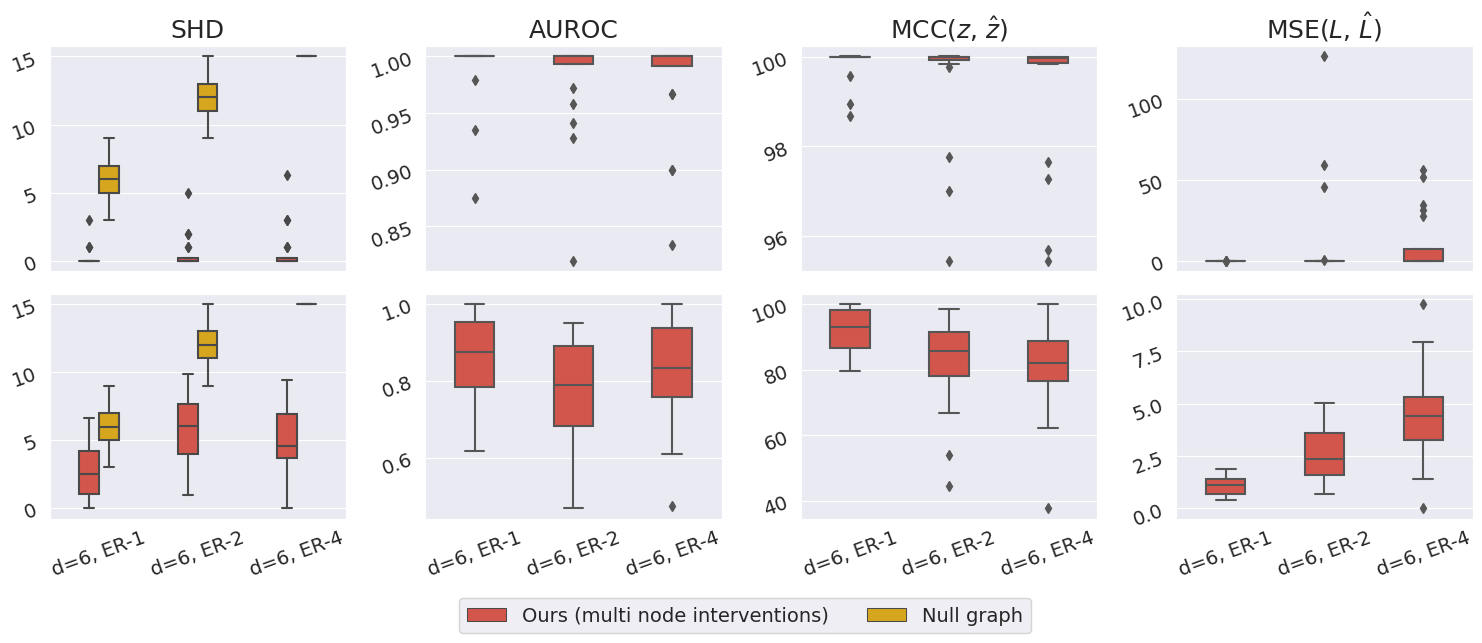

In [ ]:
d = 6
exp_names_list = [
    [       'Decoder BCD observational learn L (linear projection)',
            'Decoder BCD single interventional learn L (linear projection)',
            'Decoder BCD multi interventional learn L (linear projection)'
    ],
    [       'Decoder BCD observational learn SCM (linear projection)',
            'Decoder BCD single interventional learn SCM (linear projection)',
            'Decoder BCD multi interventional learn SCM (linear projection)'
    ]
]

linear_dbcd_d6_df = get_boxplot_d(d, exp_names_list, exp_config, reqd_keys, exp_edges_list, f'd{d}_linear_dbcd_metrics.pdf')

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: d20_linear_dbcd_metrics.pdf


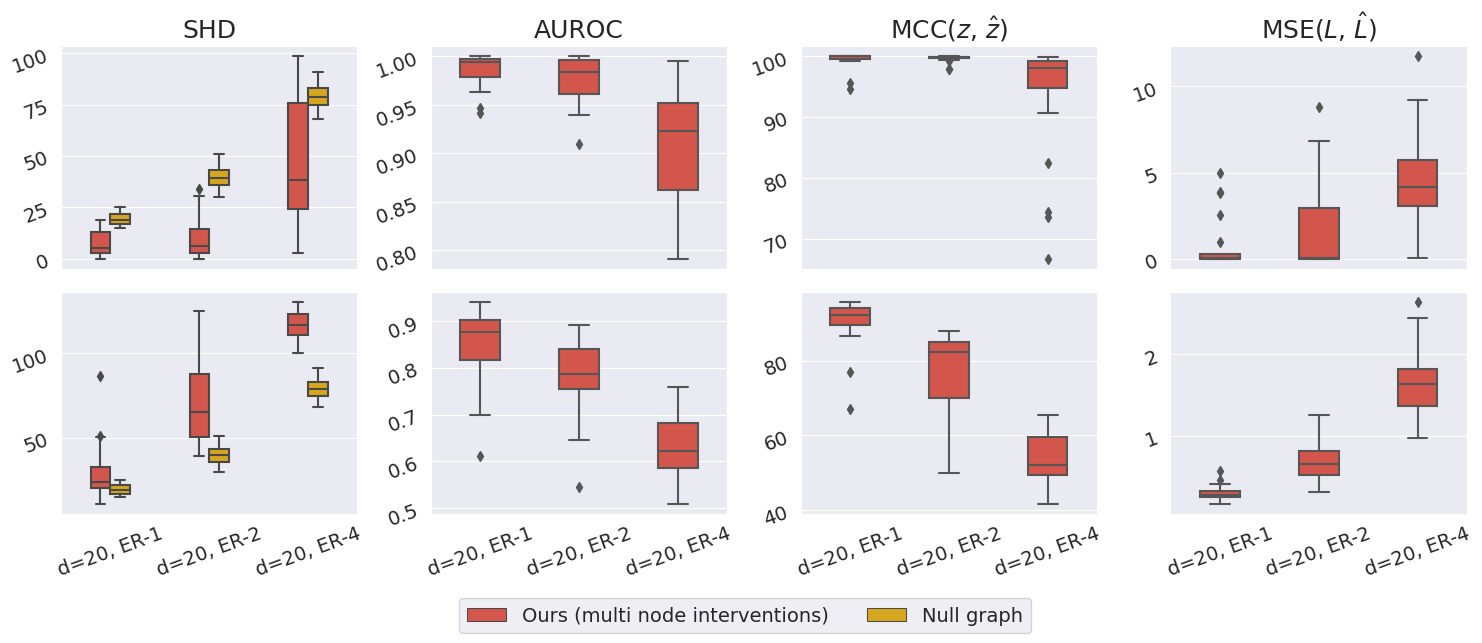

In [ ]:
d = 20
exp_names_list = [
    [       'Decoder BCD observational learn L (linear projection)',
            'Decoder BCD single interventional learn L (linear projection)',
            'Decoder BCD multi interventional learn L (linear projection)'
    ],
    [       'Decoder BCD observational learn SCM (linear projection)',
            'Decoder BCD single interventional learn SCM (linear projection)',
            'Decoder BCD multi interventional learn SCM (linear projection)'
    ]
]

linear_dbcd_d20_df = get_boxplot_d(d, exp_names_list, exp_config, reqd_keys, exp_edges_list, f'd{d}_linear_dbcd_metrics.pdf')

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: d6_nonlinear_dbcd_metrics.pdf


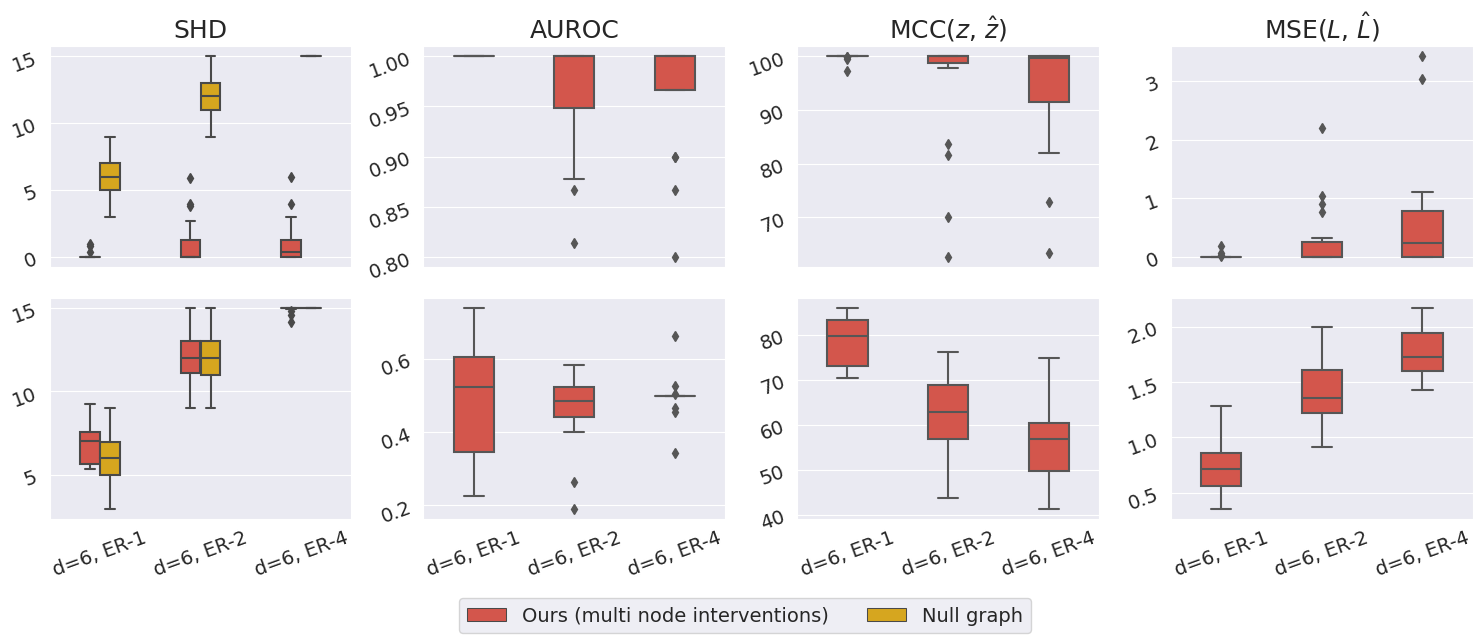

In [ ]:
d = 6
exp_names_list = [
    [       'Decoder BCD observational learn L (nonlinear projection)',
            'Decoder BCD single interventional learn L (nonlinear projection)',
            'Decoder BCD multi interventional learn L (nonlinear projection)'
    ],
    [       'Decoder BCD observational learn SCM (nonlinear projection)',
            'Decoder BCD single interventional learn SCM (nonlinear projection)',
            'Decoder BCD multi interventional learn SCM (nonlinear projection)'
    ]
]

nonlinear_dbcd_d6_df = get_boxplot_d(d, exp_names_list, exp_config, reqd_keys, exp_edges_list, f'd{d}_nonlinear_dbcd_metrics.pdf')

In [8]:
# ! Chem env
exp_config = {
    'exp_name': 'Batched Conv. Decoder BCD',
    'num_nodes': 5,
    'exp_edges': 1.0
}

reqd_keys = [   'Evaluations/SHD', 
                'Evaluations/AUROC', 
                'Evaluations/MCC', 
                'L_MSE'
            ]

exp_edges_list = [1.0, 2.0]

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: d5_conv_dbcd_chemenv_metrics.pdf


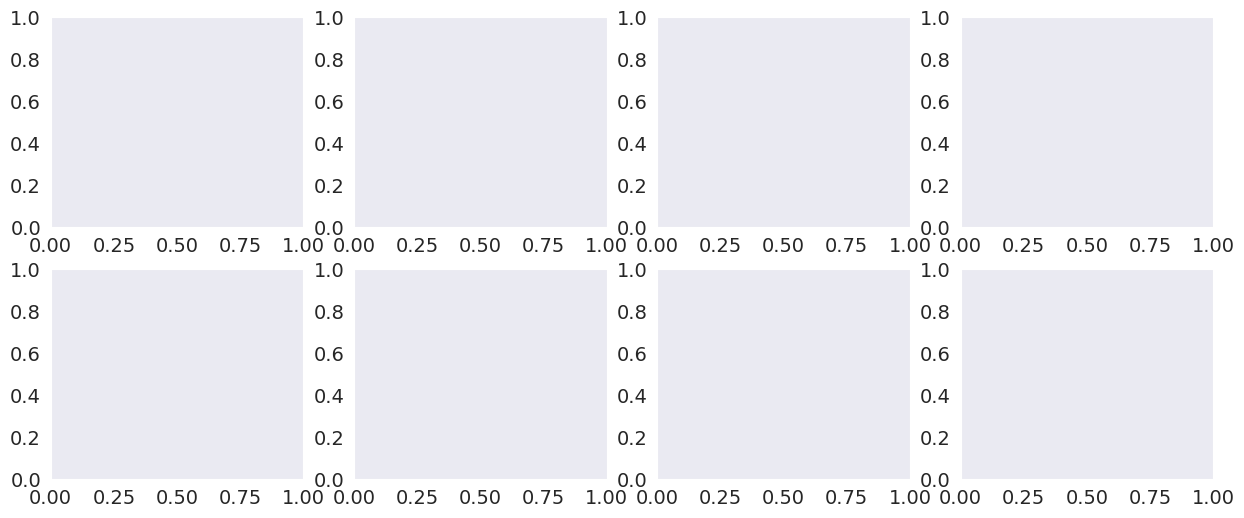

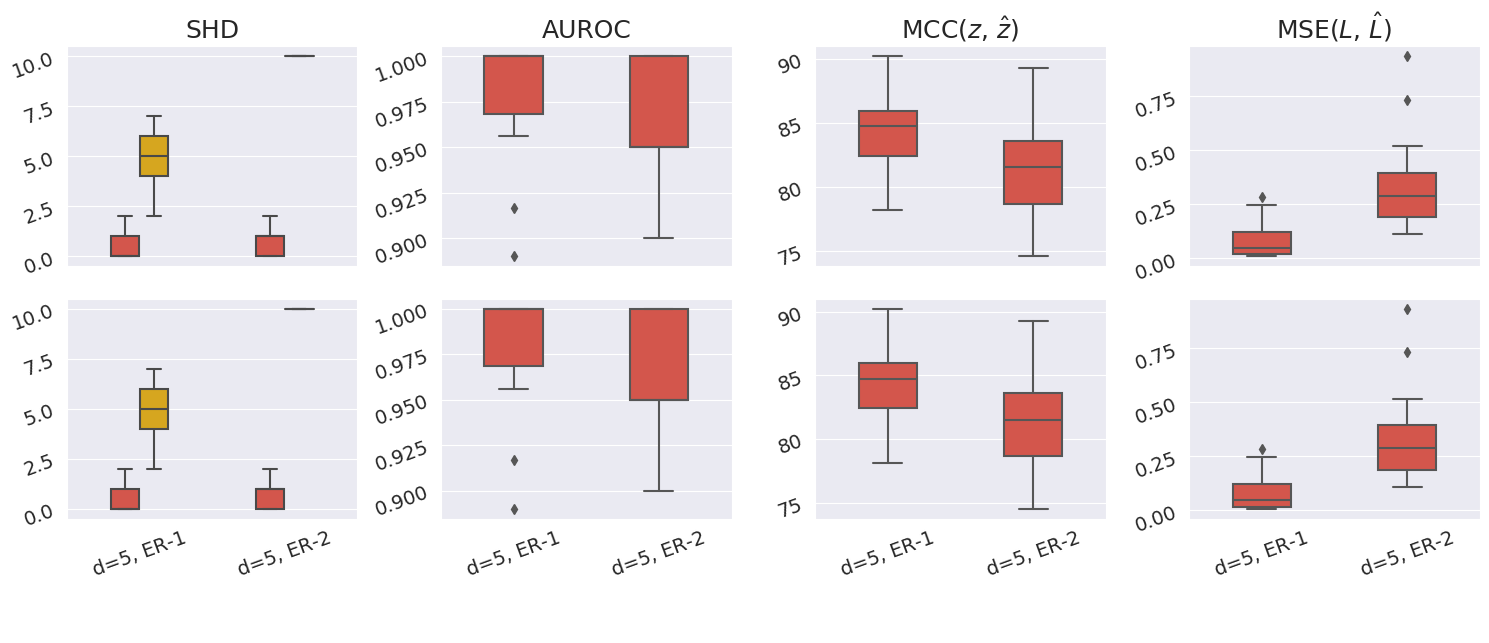

In [10]:
d = 5
exp_names_list = [
    ['Batched Conv. Decoder BCD'],
    ['Batched Conv. Decoder BCD'],
]

chemenv_d5_df = get_boxplot_d(d, exp_names_list, exp_config, reqd_keys, exp_edges_list, f'd{d}_conv_dbcd_chemenv_metrics.pdf')

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: d10_conv_dbcd_chemenv_metrics.pdf


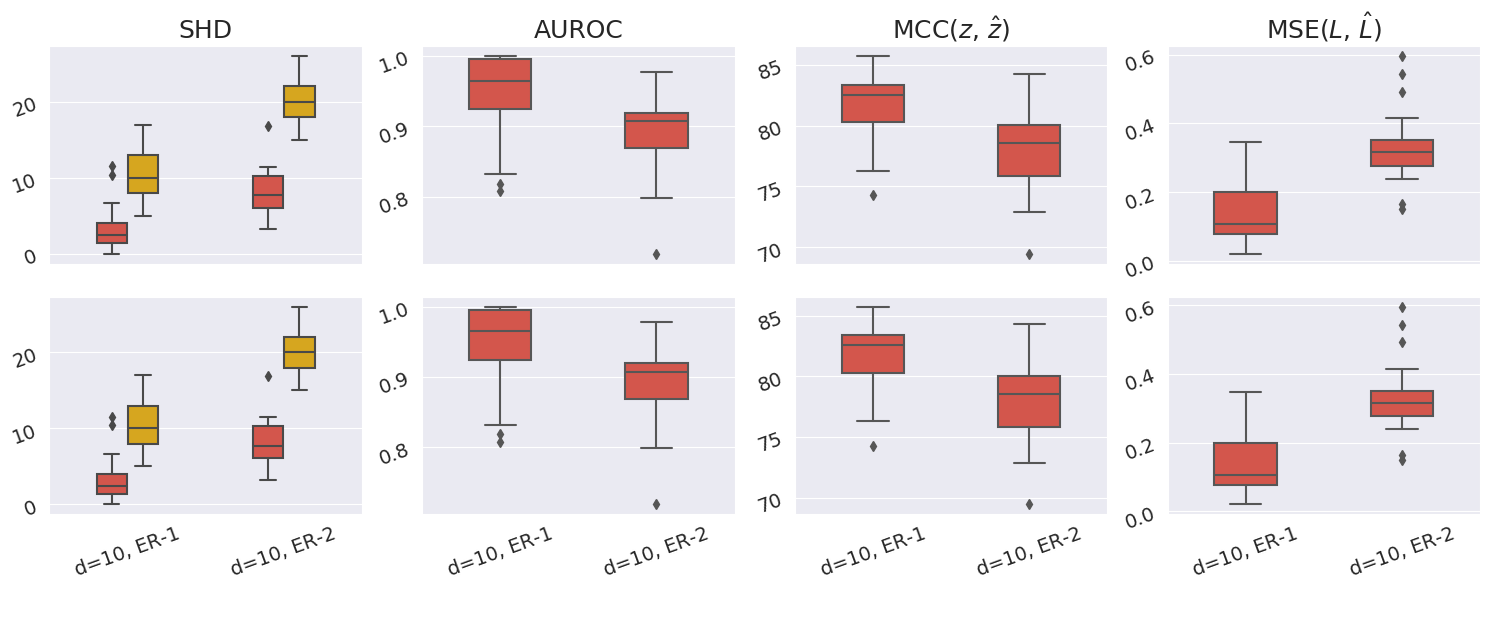

In [11]:
d = 10
exp_names_list = [
    ['Batched Conv. Decoder BCD'],
    ['Batched Conv. Decoder BCD'],
]

chemenv_d10_df = get_boxplot_d(d, exp_names_list, exp_config, reqd_keys, exp_edges_list, f'd{d}_conv_dbcd_chemenv_metrics.pdf')